In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from src.definitions import ROOT_DIR
from src.data.utils import save_pickle

In [3]:
features_fn = ROOT_DIR / 'data/interim/2016/features.pickle'
assert features_fn.exists()

In [4]:
features = pd.read_pickle(features_fn)

In [5]:
features.sample(10)

,tot_appr_val,prior_tot_appr_val,prior_land_val,im_sq_ft,fixtures_total,room_full_bath,grade_adjustment,market_area_1_dscr,dscr,date_erected,yr_remodel
869129,143000.0,144200.0,29265.0,1764.0,10.0,2.0,C+,ISD 09 - Airport Tiers Area,Average,2012,NaN
925640,189863.0,180126.0,32145.0,1809.0,11.0,2.0,C+,ISD 21 - Pasadena ISD,Average,2010,NaN
246323,91030.0,82755.0,28200.0,2045.0,5.0,1.0,C,1E Liberty/Kashmere/Houston/Croyden Gardens Areas,Average,1956,NaN
916148,136959.0,124509.0,19707.0,1894.0,10.0,2.0,C,ISD 15 - Galena Park ISD,Average,2008,NaN
933271,171581.0,165526.0,17971.0,2392.0,12.0,2.0,C,"ISD 18 - Outside Airport Tiers, Atascocita Area",Average,2013,NaN
11403,58077.0,58077.0,15000.0,1030.0,5.0,1.0,D+,"1D Lyons, Denver/Houston Harbor, Pleasantville",Low,1950,NaN
762850,111888.0,101717.0,25582.0,1379.0,9.0,2.0,C+,ISD 24 - North of Cypress Creek,Average,2004,NaN
606207,429659.0,412811.0,89251.0,2938.0,13.0,2.0,B+,"ISD 18 - Outside Airport Tiers, Atascocita Area",Good,1996,NaN
104507,60543.0,60543.0,17543.0,1292.0,10.0,2.0,C-,1C South of Old Spanish Trail btwn SH 288 and ...,Average,1955,1960.0
31977,81250.0,73864.0,46150.0,900.0,5.0,1.0,C-,ISD 21 - Pasadena ISD,Average,1955,NaN


In [6]:
features['market_area_1_dscr'].unique()

array(['1D Navigation, Harrisburg, Lawndale Areas',
       'ISD 21 - Pasadena ISD',
       '1C Midtown, Riverside Terrace, University Areas',
       '1E Ryon, Irvington, Lindale Areas',
       '1E Liberty/Kashmere/Houston/Croyden Gardens Areas',
       '1D Lyons, Denver/Houston Harbor, Pleasantville',
       '1F Montrose, Fourth Ward Areas',
       'ISD 09 - Outside Airport Tiers, East of I-45',
       '1B South of US 90, West of SH 288',
       '1F Lazybrook, Timbergrove, Washington Corridor',
       '1F Heights, Brooksmith, Norhill Areas',
       'ISD 19 - South of I-10 Katy Freeway',
       'ISD 20 - East of Bay Area Blvd',
       '1B Bellaire, West University, Southampton Areas',
       'ISD 18 - Airport Tiers South of San Jacinto River',
       '1C South of Old Spanish Trail btwn SH 288 and I-45',
       'ISD 05 - Crosby ISD',
       'ISD 09 - Outside Airport Tiers, West of I-45',
       '1F Afton Oaks, Highland Village, Weslayan Areas',
       'ISD 16 - Baytown Sterling Area',
  

In [7]:
cond0 = features['market_area_1_dscr'] == 'ISD 17 - Klein ISD'

klein = features.loc[cond0, :]

In [8]:
klein.shape

(70367, 11)

<AxesSubplot:>

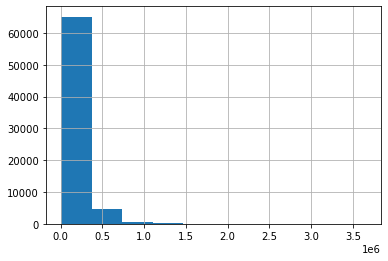

In [9]:
klein['tot_appr_val'].hist()

In [10]:
klein.columns

Index(['tot_appr_val', 'prior_tot_appr_val', 'prior_land_val', 'im_sq_ft',
       'fixtures_total', 'room_full_bath', 'grade_adjustment',
       'market_area_1_dscr', 'dscr', 'date_erected', 'yr_remodel'],
      dtype='object')

In [11]:
# cond0 = klein['tot_appr_val'] == 
cond1 = klein['prior_tot_appr_val'] == 267810
cond2 = klein['prior_land_val'] == 36313
cond3 = klein['im_sq_ft'] == 2697
cond4 = klein['fixtures_total'] == 15
cond5 = klein['room_full_bath'] == 3
cond6 = klein['dscr'] == 'Good'

In [12]:
klein.loc[cond1, :]

,tot_appr_val,prior_tot_appr_val,prior_land_val,im_sq_ft,fixtures_total,room_full_bath,grade_adjustment,market_area_1_dscr,dscr,date_erected,yr_remodel
947535,263704.0,267810.0,36313.0,2697.0,15.0,3.0,B-,ISD 17 - Klein ISD,Good,2014,NaN


In [13]:
klein = klein.drop(labels=['grade_adjustment', 'market_area_1_dscr'], axis=1)

In [14]:
klein

,tot_appr_val,prior_tot_appr_val,prior_land_val,im_sq_ft,fixtures_total,room_full_bath,dscr,date_erected,yr_remodel
22664,221551.0,183653.0,114115.0,1496.0,8.0,2.0,Average,1953,NaN
23011,214482.0,194984.0,63600.0,1828.0,8.0,2.0,Average,1985,NaN
24009,92258.0,92258.0,63600.0,1294.0,10.0,2.0,Average,1958,NaN
24010,398634.0,362395.0,264446.0,1985.0,10.0,2.0,Average,1969,2007.0
25109,84540.0,76855.0,26658.0,1070.0,8.0,2.0,Low,1980,NaN
...,...,...,...,...,...,...,...,...,...
957621,180831.0,NaN,NaN,1754.0,10.0,2.0,Average,2015,NaN
957622,224884.0,NaN,NaN,2478.0,15.0,3.0,Average,2015,NaN
957623,186283.0,NaN,NaN,1785.0,10.0,2.0,Average,2015,NaN
957624,190802.0,NaN,NaN,1859.0,10.0,2.0,Average,2015,NaN


# Turn ordinal column into numerical

In [15]:
dscr_order = {'Superior': 5, 'Excellent': 4, 'Good': 3, 'Average': 2, 'Low': 1, 'Very Low': 0}

In [16]:
klein['dscr'] = klein['dscr'].map(dscr_order)

In [17]:
klein

,tot_appr_val,prior_tot_appr_val,prior_land_val,im_sq_ft,fixtures_total,room_full_bath,dscr,date_erected,yr_remodel
22664,221551.0,183653.0,114115.0,1496.0,8.0,2.0,2,1953,NaN
23011,214482.0,194984.0,63600.0,1828.0,8.0,2.0,2,1985,NaN
24009,92258.0,92258.0,63600.0,1294.0,10.0,2.0,2,1958,NaN
24010,398634.0,362395.0,264446.0,1985.0,10.0,2.0,2,1969,2007.0
25109,84540.0,76855.0,26658.0,1070.0,8.0,2.0,1,1980,NaN
...,...,...,...,...,...,...,...,...,...
957621,180831.0,NaN,NaN,1754.0,10.0,2.0,2,2015,NaN
957622,224884.0,NaN,NaN,2478.0,15.0,3.0,2,2015,NaN
957623,186283.0,NaN,NaN,1785.0,10.0,2.0,2,2015,NaN
957624,190802.0,NaN,NaN,1859.0,10.0,2.0,2,2015,NaN


# Build latest construction year feature

In [18]:
klein['lastest_const_year'] = klein['yr_remodel'].fillna(klein['date_erected'])

In [19]:
klein

,tot_appr_val,prior_tot_appr_val,prior_land_val,im_sq_ft,fixtures_total,room_full_bath,dscr,date_erected,yr_remodel,lastest_const_year
22664,221551.0,183653.0,114115.0,1496.0,8.0,2.0,2,1953,NaN,1953.0
23011,214482.0,194984.0,63600.0,1828.0,8.0,2.0,2,1985,NaN,1985.0
24009,92258.0,92258.0,63600.0,1294.0,10.0,2.0,2,1958,NaN,1958.0
24010,398634.0,362395.0,264446.0,1985.0,10.0,2.0,2,1969,2007.0,2007.0
25109,84540.0,76855.0,26658.0,1070.0,8.0,2.0,1,1980,NaN,1980.0
...,...,...,...,...,...,...,...,...,...,...
957621,180831.0,NaN,NaN,1754.0,10.0,2.0,2,2015,NaN,2015.0
957622,224884.0,NaN,NaN,2478.0,15.0,3.0,2,2015,NaN,2015.0
957623,186283.0,NaN,NaN,1785.0,10.0,2.0,2,2015,NaN,2015.0
957624,190802.0,NaN,NaN,1859.0,10.0,2.0,2,2015,NaN,2015.0


In [21]:
klein.drop('yr_remodel', axis=1, inplace=True)

# Check for NaNs

In [22]:
klein.isna().sum() / klein.shape[0]

tot_appr_val          0.000000
prior_tot_appr_val    0.003396
prior_land_val        0.003396
im_sq_ft              0.000000
fixtures_total        0.000000
room_full_bath        0.000000
dscr                  0.000000
date_erected          0.000000
lastest_const_year    0.000000
dtype: float64

## Remove NaNs

In [23]:
klein = klein.dropna().copy()

# Get the appraised value difference

In [24]:
from scipy import stats

import seaborn as sns

In [25]:
klein['appr_val_diff'] = klein['tot_appr_val'] - klein['prior_tot_appr_val']

<AxesSubplot:>

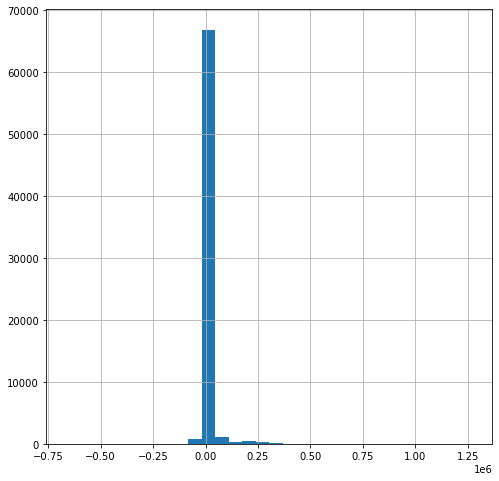

In [26]:
plt.figure(figsize=(8, 8))
klein['appr_val_diff'].hist(bins=30)

In [27]:
klein.loc[klein['appr_val_diff'] > 100_000]

,tot_appr_val,prior_tot_appr_val,prior_land_val,im_sq_ft,fixtures_total,room_full_bath,dscr,date_erected,lastest_const_year,appr_val_diff
35447,258817.0,154000.0,43560.0,1804.0,9.0,2.0,2,1983,1983.0,104817.0
42539,274500.0,137250.0,25834.0,3477.0,16.0,3.0,2,2014,2014.0,137250.0
42737,758300.0,235743.0,81880.0,2268.0,11.0,2.0,2,1929,1929.0,522557.0
43449,277259.0,132833.0,130680.0,2120.0,8.0,2.0,2,1966,1966.0,144426.0
44624,274296.0,161406.0,74991.0,1920.0,5.0,1.0,2,1971,1971.0,112890.0
...,...,...,...,...,...,...,...,...,...,...
957394,306477.0,18224.0,18224.0,3013.0,13.0,3.0,3,2015,2015.0,288253.0
957482,330000.0,49042.0,49042.0,3887.0,16.0,3.0,3,2015,2015.0,280958.0
957483,349343.0,49831.0,49831.0,3952.0,16.0,3.0,3,2015,2015.0,299512.0
957484,246140.0,41425.0,41425.0,2072.0,13.0,3.0,3,2015,2015.0,204715.0


In [28]:
klein['appr_val_diff'].describe()

count    7.012800e+04
mean     1.597404e+04
std      3.751980e+04
min     -6.631820e+05
25%      5.838000e+03
50%      1.140000e+04
75%      1.716925e+04
max      1.270945e+06
Name: appr_val_diff, dtype: float64

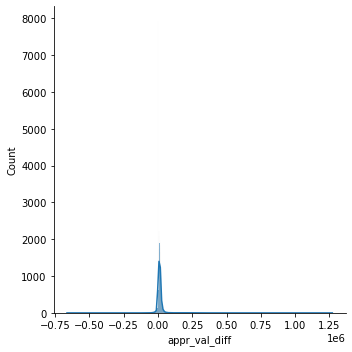

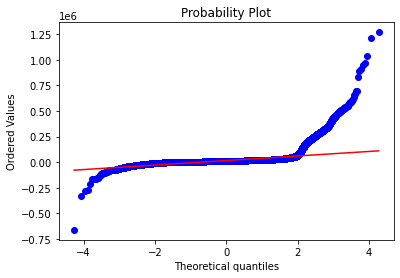

In [29]:
# sns.distplot(klein['appr_val_diff'], fit=stats.norm)
sns.displot(klein['appr_val_diff'], kde=True)
fig = plt.figure()
res = stats.probplot(klein['appr_val_diff'], plot=plt)

Those really high positive differences are new builds.

In [30]:
cond0 = ~(klein['lastest_const_year'] >= 2015)

klein = klein.loc[cond0, :]

<AxesSubplot:>

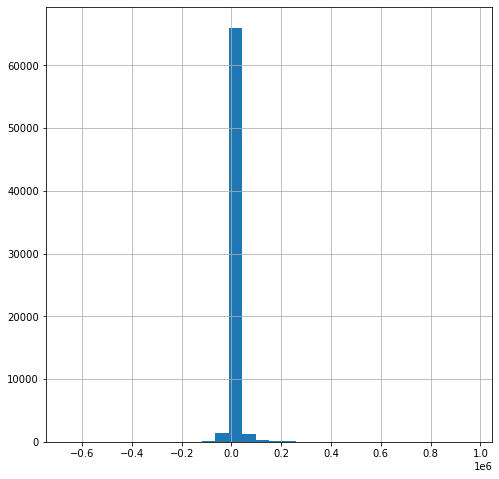

In [31]:
klein['appr_val_diff'].hist(bins=30, figsize=(8, 8))

In [32]:
klein.shape

(69227, 10)

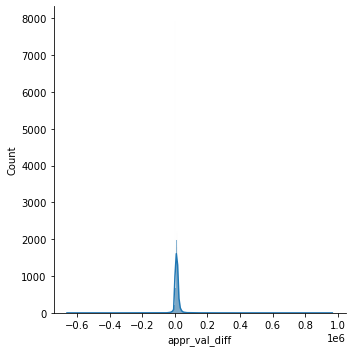

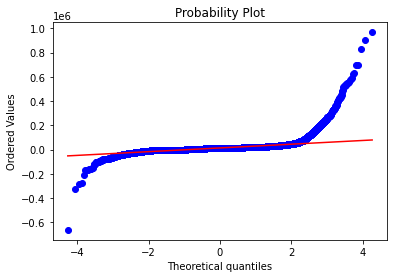

In [33]:
# sns.distplot(klein['appr_val_diff'], fit=stats.norm)
sns.displot(klein['appr_val_diff'], kde=True)
fig = plt.figure()
res = stats.probplot(klein['appr_val_diff'], plot=plt)

# Find neighbours

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
ks = range(1, 12)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(klein)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Seems like 6 is a good choice

In [ ]:
model = KMeans(n_clusters=6)

In [ ]:
labels = model.fit_predict(klein)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
model = TSNE(learning_rate=100)

In [ ]:
transformed = model.fit_transform(klein)

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(transformed[:, 0], transformed[:, 1], c=labels, cmap='Set1', alpha=0.5, s=0.5)
plt.colorbar()
plt.show()

In [ ]:
klein_labeled = klein.copy()

klein_labeled['kmeans_label'] = labels

In [ ]:
klein_labeled

In [ ]:
klein_labeled.loc[947535, :]

In [ ]:
appraised_2016 = 292707
appraised_2015 =  267810

appraised_2016 - appraised_2015

So my house is in label 4

In [ ]:
cond0 = klein_labeled['kmeans_label'] == 0

comps = klein_labeled.loc[cond0, :]

In [ ]:
comps.sample(10)

In [ ]:
comps.shape

In [ ]:
plt.figure(figsize=(8, 8))
comps['tot_appr_val'].hist(bins=30)

In [ ]:
mean = comps['tot_appr_val'].mean()
std = comps['tot_appr_val'].std()

In [ ]:
z = (comps['tot_appr_val'] - mean) / std

In [ ]:
my_value = 263704.0

In [ ]:
z_my_value = (my_value - mean) / std

In [ ]:
plt.figure(figsize=(8, 8))
z.hist(bins=30)

In [ ]:
# cond1 = klein['prior_tot_appr_val'] == 267810
# cond2 = klein['prior_land_val'] == 36313
cond3 = klein['im_sq_ft'].between(2697 - 100, 2697 + 100)
cond4 = klein['fixtures_total'] == 15
cond5 = klein['room_full_bath'] == 3
cond6 = klein['dscr'] == 3

neighbours = klein.loc[cond3 & cond4 & cond5 & cond6, :]

In [ ]:
plt.figure(figsize=(8, 8))
neighbours['prior_tot_appr_val'].hist(bins=30)

In [ ]:
neighbours.shape

In [ ]:
neighbours.shape

In [ ]:
neighbours['last_year_appr_diff'] = neighbours['tot_appr_val'] - neighbours['prior_tot_appr_val']

In [ ]:
neighbours

In [ ]:
plt.figure(figsize=(8, 8))
neighbours['last_year_appr_diff'][neighbours['last_year_appr_diff'] < 50000].hist(bins=50)

In [ ]:
neighbours['prior_land_val'].hist(bins=30)